## Rodrigo Xavier
## Matrícula 569037

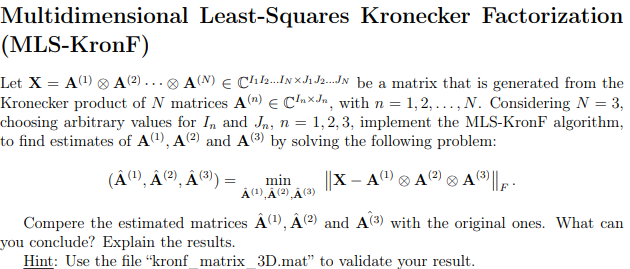

In [15]:
import numpy as np
import multilinear_algebra as ma
import matplotlib.pyplot as plt
from typing import Union
from scipy.io import loadmat


# Testing with krd_matrix_3D.mat file:
mat_file = loadmat(r"C:\Users\Administrador\Documents\Doutorado\Algebra tensorial\Homeworks\matlab files\kronf_matrix_3D.mat")
X = mat_file['X']
A1 = mat_file['A']
A2 = mat_file['B']
A3 = mat_file['C']

print(f'X shape: {X.shape}')
print(f'A1 shape: {A1.shape}')
print(f'A2 shape: {A2.shape}')
print(f'A3 shape: {A3.shape}')

X shape: (96, 30)
A1 shape: (4, 3)
A2 shape: (4, 2)
A3 shape: (6, 5)


In [219]:
def vec(matrix):
    return matrix.flatten(order='F').reshape(-1, 1)
    
def dB2linear(x: Union[int, np.ndarray]) -> any:
    """ Function to convert logarithmic scale to linear.
    Parameters:
    ---
    x : [scalar or 2-D array]
        Input data [dB].

    Returns:
    ---
    out: [scalar or 2-D array]
        Output data [linear (e.g.: watts)].
    """
    return 10**(x/10)

def alphaV(X: np.ndarray, snr_db: Union[int, float]):
    """Function to compute 'a' to control the noise of a signal."""
    V = np.random.normal(0, 1, X.shape) + 1j*np.random.normal(0, 1, X.shape)
    snr_linear = dB2linear(snr_db)
    alphaV_ = (np.linalg.norm(X, 'fro')**2)/snr_linear
    alpha = np.sqrt(alphaV_/(np.linalg.norm(X, 'fro')**2))
    return alpha*V

In [16]:
def mlskronf(matrix, shapes, known_values, SNR_dB):
    """
    Performs Multidimensional Least-Squares Kronecker Factorization on a 
    third-order tensor.

    Args:
        X: The input tensor (3D numpy array).
        shapes: The known shapes of A1 A2 A3 (list of tuples)
        known_values: A list of at least 1 value in A1 A2 A3 (python list)
        SNR_DB: noise to be added to X in dB (int)

    Returns:
        A1_hat
        A2_hat
        A3_hat
        X_hat
    """
    A1_row, A1_col = shapes[0]
    A2_row, A2_col = shapes[1]
    A3_row, A3_col = shapes[2]
    
    # Extracting Xn blocks
    nrow_a, ncol_a = shapes[0]
    nrow_b, ncol_b = [int(x / y) for x, y in zip(matrix.shape, shapes[0])]
    
    split = np.array(np.hsplit(matrix, ncol_a))

    aux = split.reshape(nrow_a * ncol_a, nrow_b, ncol_b)

    nrow_a, ncol_a = shapes[1]
    nrow_b, ncol_b = [int(x / y) for x, y in zip((nrow_b, ncol_b), shapes[1])]

    if np.iscomplexobj(matrix):
        out_x = np.zeros((nrow_b * ncol_b * nrow_a * ncol_a, np.prod(shapes[0])),
                         dtype=np.complex_)
    else:
        out_x = np.zeros((nrow_b * ncol_b * nrow_a * ncol_a, np.prod(shapes[0])))

    for s in range(aux.shape[0]):
        split_aux = np.array(np.hsplit(aux[s], ncol_a))
        split_aux = split_aux.reshape(nrow_a * ncol_a, nrow_b, ncol_b)
        out_x[:, [s]] = ma.vec(split_aux.T.reshape(nrow_b * ncol_b, nrow_a * ncol_a))

    Xn = []
    for i in range(A1_row*A1_col):
        xi = out_x[:,i].reshape(A2_row*A3_row,A2_col*A3_col)
        Xn.append(xi)
        
    X_reshaped = np.concatenate([xn.reshape(-1) for xn in Xn]) # Vectorize and transpose each Xn
    X_reshaped = X_reshaped.reshape(A1_row*A1_col, A2_row*A2_col*A3_row*A3_col)
    
    # Creating tensor
    X_tensor = ma.fold(X_reshaped.T, (A3_row*A3_col,A2_row*A2_col,A1_row*A1_col), 1)
    
    # Applying HOSVD
    S, U1, U2, U3 = ma.hosvd(X_tensor)
    
    # Estimating A1 A2 A3
    A3_hat = U1[:,0].reshape(A3.shape[0],A3.shape[1], order='F')
    A2_hat = U2[:,0].reshape(A2.shape[0],A2.shape[1], order='F')
    A1_hat = U3[:,0].reshape(A1.shape[0],A1.shape[1], order='F')
    
    # Estimating scale factor based on known values of A1 A2 A3
    scale_facror_A1 = known_values[0] / A1_hat[0][0]
    scale_facror_A2 = known_values[1] / A2_hat[0][0]
    scale_facror_A3 = known_values[2] / A3_hat[0][0]
    
    # Approximating A1_hat A2_hat A3_hat
    A1_hat = A1_hat*scale_facror_A1
    A2_hat = A2_hat*scale_facror_A2
    A3_hat = A3_hat*scale_facror_A3
    
    X_hat = np.kron(A1_hat, np.kron(A2_hat, A3_hat))
    
    # Adding AWGN noise:
    if SNR_dB != None:
        X_hat = X_hat + ma.alphaV(X_hat, SNR_dB)
    else:
        pass
    
    return A1_hat, A2_hat, A3_hat, X_hat

In [17]:
shapes = [A1.shape, A2.shape, A3.shape]
known_values = [A1[0][0], A2[0][0], A3[0][0]]
snr_db = None

A1_hat, A2_hat, A3_hat, X_hat = mlskronf(X, shapes, known_values, snr_db)

In [18]:
print("NMSE (A1_hat) = ", ma.NMSE(A1, A1_hat))
print("NMSE (A2_hat) = ", ma.NMSE(A2, A2_hat))
print("NMSE (A3_hat) =", ma.NMSE(A3, A3_hat))
print("NMSE (X_hat) =", ma.NMSE(X, X_hat))

NMSE (A1_hat) =  8.945011713918048e-32
NMSE (A2_hat) =  3.8138119962306803e-31
NMSE (A3_hat) = 7.191866959135191e-32
NMSE (X_hat) = 2.448992022506968e-31


Conhecendo pelo menos um elemento das matrizes A1, A2 e A3, suas dimensões e tendo um sinal recebido X, é possível estimar o sinal original por meio da função mlskronf

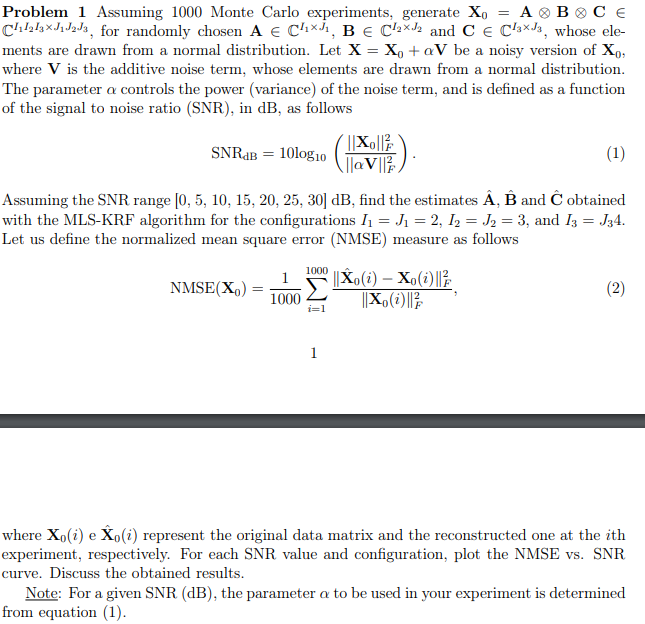

In [263]:
I1, J1 = (2,2)
I2, J2 = (3,3)
I3, J3 = (4,4)

SNR_dB_range = [0, 5, 10, 15, 20, 25, 30]
num_experiments = 1000

# Run simulations for the first set of parameters (I1, J1, P1, Q1)
nmse_results = np.zeros((num_experiments, len(SNR_dB_range)))
for ind_run in range(num_experiments):
    for snr_idx, snr in enumerate(SNR_dB_range):
        A1 = np.random.randn(I1,J1)
        A2 = np.random.randn(I2,J2)
        A3 = np.random.randn(I3,J3)
        X = np.kron(A1, np.kron(A2, A3))
        
        shapes = [A1.shape, A2.shape, A3.shape]
        known_values = [A1[0][0], A2[0][0], A3[0][0]]
        
        # Running the MLSKronF:
        _, _, _, X_hat = mlskronf(X, shapes, known_values, snr)
        nmse_results[ind_run, snr_idx] = ma.NMSE(X, X_hat)

# Take the mean of the independent runs (for the first set)
nmse_results = nmse_results.mean(axis=0)

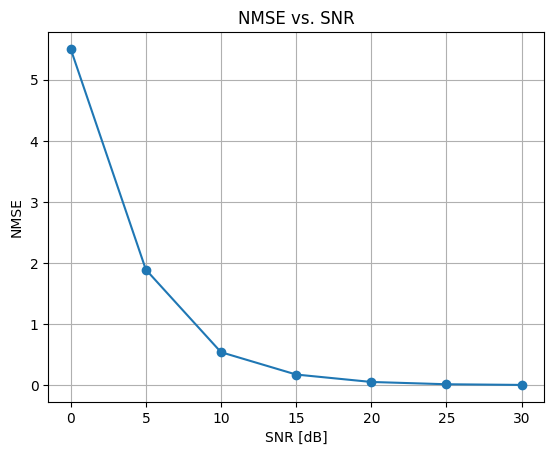

In [264]:
# Plotting
_ = plt.figure()  # Create a new figure for clarity

# Plot results for the first set of parameters (I1, J1)
plt.plot(SNR_dB_range, nmse_results, marker='o')

plt.grid(True, which="both")
plt.xlabel("SNR [dB]")
plt.ylabel("NMSE")
plt.title("NMSE vs. SNR")
plt.show()